In [214]:
from lib.image.line_detection import get_contours_of_table
from lib.relative import path_join
from cv2 import imread, IMREAD_UNCHANGED

test_image = imread(path_join("../", "test_files", "3516793810.tif"), IMREAD_UNCHANGED)

headers, body, footer = get_contours_of_table(test_image)

275


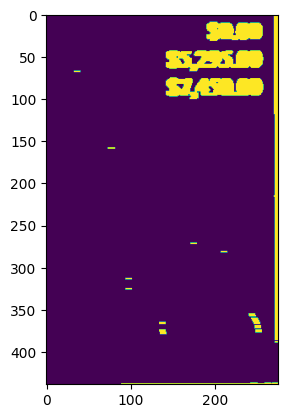

In [222]:
from lib.image.color_space import invert
import cv2
from lib.image.parse_body import get_body_rows
from lib.image.cell import cut_cells, cell_optimise_for_scan
from matplotlib.pyplot import imshow

body_cuts = cut_cells(body, test_image)
# optimised_body_cuts = [cell_optimise_for_scan(body_cut) for body_cut in body_cuts]
# body_rows_separated = [get_body_rows(row) for row in optimised_body_cuts]

selected_cell = invert(body_cuts[2])

scale_ratio = 1

width = int(selected_cell.shape[1] * scale_ratio)
height = int(selected_cell.shape[0] * scale_ratio)
resized_selected_cell = cv2.resize(selected_cell, (width, height), interpolation=cv2.INTER_AREA)

print(selected_cell.shape[1])

# .01 and .08 % of total width of total width (as table size is relatively stable)
kernel_width = int(0.01 * selected_cell.shape[1])
kernel_height = int(0.03 * selected_cell.shape[1])

rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_height, kernel_width))
dilated = cv2.dilate(resized_selected_cell, rect_kernel, iterations=1)

imshow(dilated)

In [216]:
from lib.image.line_detection import get_contours_of_table
from lib.relative import path_join
from cv2 import imread, IMREAD_UNCHANGED

test_image = imread(path_join("../", "test_files", "3516793810.tif"), IMREAD_UNCHANGED)

headers, body, footer = get_contours_of_table(test_image)

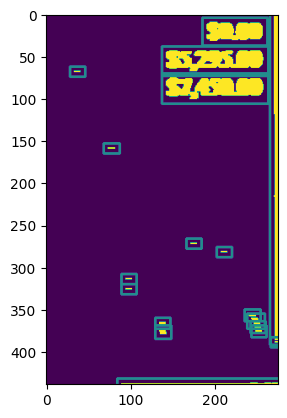

In [225]:
from lib.image.draw import rectangle_points_from_contours
from matplotlib.pyplot import figure
from cv2 import imread, IMREAD_UNCHANGED, rectangle

text_possible_contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
len(text_possible_contours)

for contour in text_possible_contours:
    figure(1)
    rectangle(dilated, *rectangle_points_from_contours(contour, 5), (125, 0, 0), 2)

imshow(dilated)

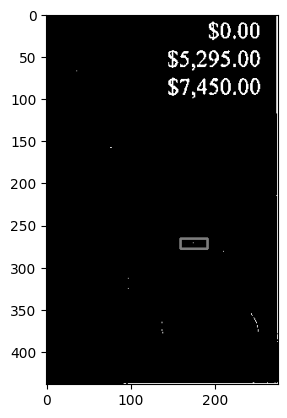

In [218]:
draw_one_contour = selected_cell.copy()
# for each contour

contour = text_possible_contours[11]

rectangle(draw_one_contour, *rectangle_points_from_contours(contour, 5), (125, 0, 0), 2)

imshow(draw_one_contour, cmap='gray')

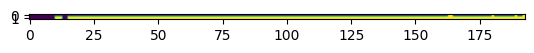

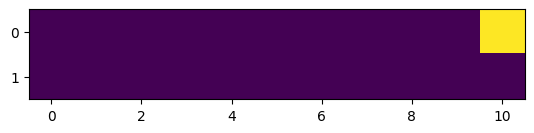

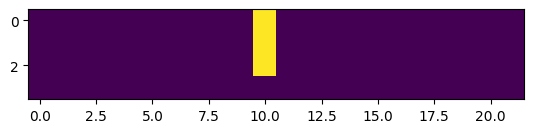

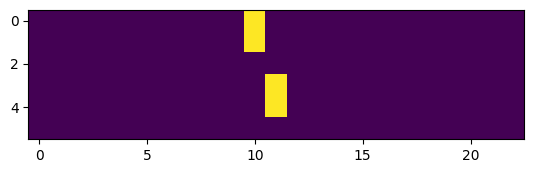

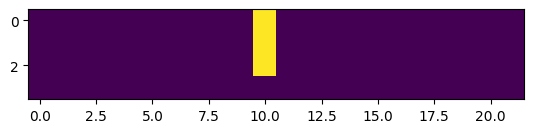

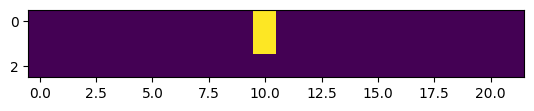

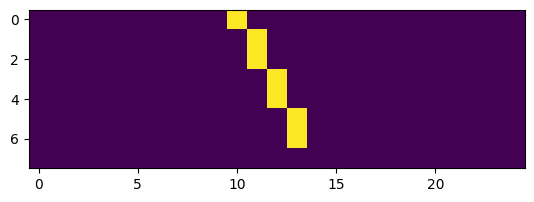

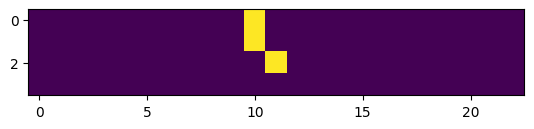

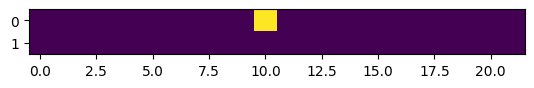

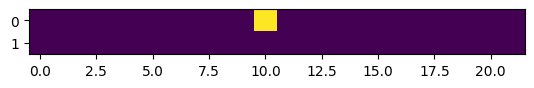

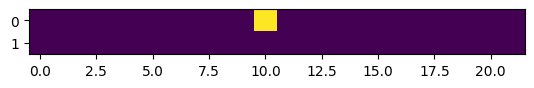

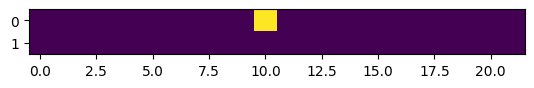

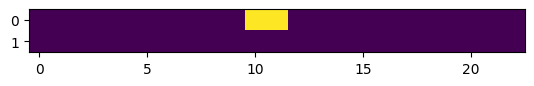

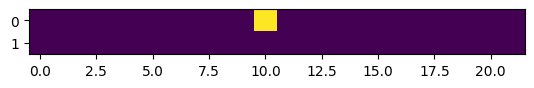

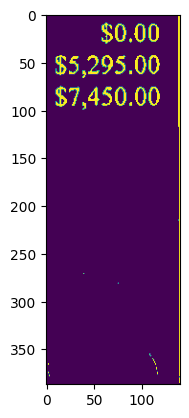

In [223]:
from lib.image.cell import crop_image_cell
from cv2 import boundingRect

column = selected_cell.copy()

row_cutouts = [crop_image_cell(column, boundingRect(contour)) for contour in text_possible_contours]

for index, row_cutout in enumerate(row_cutouts):
    figure(index)
    imshow(row_cutout)

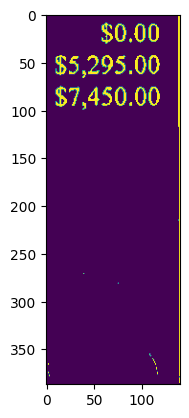

In [224]:
filtered_cutouts = [cutout for cutout in row_cutouts if cutout.shape[0] >= 20 and cutout.shape[1] >= 20]

# sort vertical

for index, row_cutout in enumerate(filtered_cutouts):
    figure(index)
    imshow(row_cutout)

In [221]:
import re
from pytesseract import image_to_data, Output, image_to_string
from PIL.Image import fromarray
from numpy import ndarray
from lib.image.cell import cell_line_to_text


def cell_row_to_text(image: ndarray) -> list[str]:
    pillow_image = fromarray(image)
    return image_to_string(pillow_image, config='--psm 7')

def have_character_or_number(text: str) -> bool:
    alpha_numeric = re.compile('[a-zA-Z0-9]{1,}')
    return alpha_numeric.search(text) is not None


# sort vertical
# ocr on each row_cutout
parsed = [cell_row_to_text(row_cutout) for row_cutout in filtered_cutouts]
filtered = [text.strip() for text in parsed if have_character_or_number(text)]

filtered

['$9509']